In [1]:

import sys
from pathlib import Path

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

# Xử lý dữ liệu

## Lấy dữ liệu

Lấy dữ liệu từ file CSV

In [3]:
# Lấy dữ liệu từ nguồn sẵn có
import sys
import os
import talib as ta
sys.path.append('d:\\NCKH\\SARSA_FinancialRL')  # Thêm đường dẫn gốc để import module

import pandas as pd
from data.data_processor.feature_engineer import engineer_stat as es
from data.split_data.split import split_data_two_parts
from environments.stock_trading_env.mdp import StockTradingMDP as stockMDP
from agents.d_sarsa.d_sarsa import train_deep_sarsa

# Định nghĩa đường dẫn gốc
base_path = 'd:\\NCKH\\SARSA_FinancialRL'

# Lấy dữ liệu tạm từ nguồn sẵn có
csv_path = os.path.join(base_path, 'data', 'data_storer', 'FPT_detail_2013_01_01_2024_12_31.csv')
df = pd.read_csv(csv_path)
df

,time,open,high,low,close,volume
0,20-06-2012,5.31,5.31,5.27,5.29,89720
1,21-06-2012,5.28,5.29,5.26,5.28,50360
2,22-06-2012,5.27,5.28,5.26,5.26,67350
3,25-06-2012,5.25,5.29,5.25,5.26,42840
4,26-06-2012,5.22,5.24,5.22,5.22,31110
...,...,...,...,...,...,...
3128,25-12-2024,129.85,130.37,129.68,130.02,2517969
3129,26-12-2024,130.19,130.54,128.56,129.16,2238343
3130,27-12-2024,128.90,129.25,128.21,128.99,2567003
3131,30-12-2024,128.81,130.02,128.04,129.76,1986819


## Tính toán các chỉ báo kĩ thuật

In [4]:
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').reset_index(drop=True)

# Gọi hàm với start_date và config tùy chỉnh
start_date = pd.to_datetime('01-01-2013', format='%d-%m-%Y')
price_history = es.add_technical_indicators(
    df, 
    start_date=start_date
)
# df_with_indicators giờ đã có các cột chỉ số, gắn vào df gốc của bạn
price_history

C:\Users\Admin\AppData\Local\Temp\ipykernel_5428\1549584949.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['time'] = pd.to_datetime(df['time'])


,time,open,high,low,close,volume,MACD,RSI,CCI,ADX
0,02/01/2013,4.00,4.15,4.00,4.13,380320,0.062248,72.002503,253.212693,26.054096
1,03/01/2013,4.13,4.15,4.00,4.07,366960,0.073297,66.503579,180.086580,28.047868
2,04/01/2013,4.05,4.13,4.04,4.13,278020,0.085905,69.049162,156.238566,29.899227
3,07/01/2013,4.11,4.14,4.08,4.11,204570,0.093209,67.215490,133.887463,31.676318
4,08/01/2013,4.12,4.31,4.11,4.31,535860,0.113823,74.506365,161.115250,34.114683
...,...,...,...,...,...,...,...,...,...,...
2991,25/12/2024,129.85,130.37,129.68,130.02,2517969,2.858353,67.076480,80.770363,34.110079
2992,26/12/2024,130.19,130.54,128.56,129.16,2238343,2.718885,63.212308,61.673685,33.596240
2993,27/12/2024,128.90,129.25,128.21,128.99,2567003,2.565070,62.446483,34.093919,32.865699
2994,30/12/2024,128.81,130.02,128.04,129.76,1986819,2.476752,64.541897,51.584632,32.527327


## Chia dữ liệu

In [5]:
train, test = split_data_two_parts(price_history, train_portion=0.8)
print(f"Train size: {len(train)}, Test size: {len(test)}")
train

Train size: 2396, Test size: 600


,time,open,high,low,close,volume,MACD,RSI,CCI,ADX
0,02/01/2013,4.00,4.15,4.00,4.13,380320,0.062248,72.002503,253.212693,26.054096
1,03/01/2013,4.13,4.15,4.00,4.07,366960,0.073297,66.503579,180.086580,28.047868
2,04/01/2013,4.05,4.13,4.04,4.13,278020,0.085905,69.049162,156.238566,29.899227
3,07/01/2013,4.11,4.14,4.08,4.11,204570,0.093209,67.215490,133.887463,31.676318
4,08/01/2013,4.12,4.31,4.11,4.31,535860,0.113823,74.506365,161.115250,34.114683
...,...,...,...,...,...,...,...,...,...,...
2391,03/08/2022,52.79,52.91,52.29,52.66,2249500,-0.282071,48.924259,49.201785,12.196316
2392,04/08/2022,52.85,53.78,52.73,53.47,3046800,-0.184177,54.205961,119.040767,12.341111
2393,05/08/2022,53.47,54.16,53.16,53.29,1773100,-0.119740,52.896895,126.292534,12.815912
2394,08/08/2022,53.35,53.66,52.98,53.41,1586800,-0.058318,53.699666,96.895460,13.022593


# Triển khai chính sách ngẫu nhiên
làm tiên chuẩn (baseline) để so sánh với kết quả với kết quả của ba agent sắp tới.

Chính sách này không học hỏi gì, chỉ chọn hành động ngẫu nhiên đều đặn, như tung xúc xắc để quyết định mua/bán.

Chạy trên tập test

In [6]:
# Định nghĩa danh sách hành động (A) - cần thiết cho pi_random
balance_init = 1000  # số dư ban đầu
k = 5  # số cổ phiếu tối đa
min_balance = -100  # ngưỡng số dư tối thiểu
A = [a for a in range(-k, k + 1, 1)]  # hành động: -5 đến +5

# Tạo instance của StockTradingMDP
mdp = stockMDP(balance_init=balance_init, k=k, min_balance=min_balance)

# policy
def pi_random(s, greedy=False, eps=0.2):
    return np.random.choice(A) # random policy (uniform distributed)

profits = list()
for rep in tqdm(range(20)):
    profit = mdp.interact_test(
        pi=pi_random,  # chính sách (hàm pi_random)
        train_series=train,  # DataFrame train (từ cell chia dữ liệu)
        test_series=test,  # DataFrame test (từ cell chia dữ liệu)
        series_name='test',  # chạy trên tập test
        verbose=False  # không hiển thị biểu đồ (chỉ thu thập dữ liệu)
    )
    profits.append(profit)
print("Avg Profit", np.mean(profits))
print('STD Profit', np.std(profits))

100%|██████████| 20/20 [00:02<00:00,  8.40it/s]

Avg Profit 642.5261210000001
STD Profit 207.1126295182679


# Huấn luyện agent Deep - SARSA



RUNNING POLICY GRADIENT EXPERIMENTS


Running Policy Gradient 3 times: 100%|██████████| 3/3 [09:15<00:00, 185.22s/it]




EXPERIMENT SUMMARY

Policy Gradient:
  • Average Final Profit: $-505.22 ± $417.26
  • Best Training Profit: $-453.26
  • Training Stability (std): $427.46


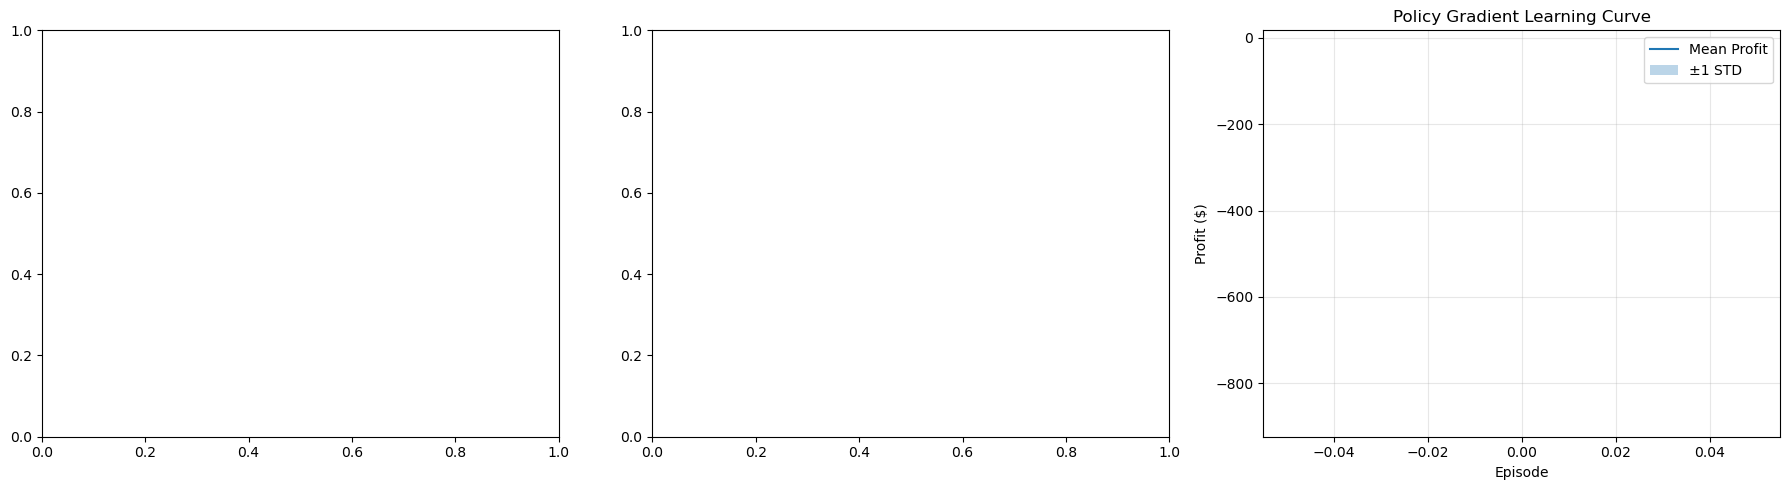


FINAL RESULTS SUMMARY

Policy Gradient:
  • Average Final Profit: $-505.22 ± $417.26
  • Best Profit: $-4.01
  • Worst Profit: $-1025.54
  • Peak Training Profit: $-453.26

Random Policy Baseline:
  • Average Profit: $642.53 ± $207.11


In [8]:
# Import run_experiments từ agents.run
from agents.run import run_experiments

# Định nghĩa shared_config với các siêu tham số chung cho tất cả agent
shared_config = {
    'episodes': 100,         # Tăng số episodes để agent học tốt hơn
    'gamma': 0.99,           # Tăng gamma để xem xét reward xa hơn
    'alpha': 0.7,            # Learning rate α (cho SARSA)
    'epsilon_start': 0.8,    # Initial ϵ policy
    'epsilon_min': 0.01,     # Giảm minimum ϵ để khám phá ít hơn
    'epsilon_decay': 0.995,  # ϵ Decay chậm hơn
    'nn_epochs': 10,         # Epochs for Updating NN (cho SARSA)
    'nn_lr': 1e-4,           # Tăng Learning Rate for NN
    'enabled_agents': [0, 0, 1]  # [SARSA, DQN, PG]: 1 để bật, 0 để tắt
}

# Chạy thử nghiệm cho agent được bật với cùng siêu tham số
results = run_experiments(mdp, train, test, shared_config, num_runs=3)

# Hiển thị kết quả
import matplotlib.pyplot as plt

# Vẽ learning curves cho từng agent
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

agents = ['sarsa', 'dqn', 'pg']
titles = ['Deep SARSA', 'DQN', 'Policy Gradient']

for i, (agent, title) in enumerate(zip(agents, titles)):
    if agent in results:
        res = results[agent]
        mean_curve = res['learning_curve']
        std_curve = res['std_learning_curve']
        
        axes[i].plot(mean_curve, label='Mean Profit')
        axes[i].fill_between(range(len(mean_curve)), 
                           mean_curve - std_curve, 
                           mean_curve + std_curve, 
                           alpha=0.3, label='±1 STD')
        axes[i].set_title(f'{title} Learning Curve')
        axes[i].set_xlabel('Episode')
        axes[i].set_ylabel('Profit ($)')
        axes[i].legend()
        axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# In tóm tắt kết quả
print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)

for agent in agents:
    if agent in results:
        res = results[agent]
        print(f"\n{res['agent']}:")
        print(f"  • Average Final Profit: ${res['final_profit']:.2f} ± ${res['std_final_profit']:.2f}")
        print(f"  • Best Profit: ${np.max(res['all_final_profits']):.2f}")
        print(f"  • Worst Profit: ${np.min(res['all_final_profits']):.2f}")
        if len(res['learning_curve']) > 0:
            print(f"  • Peak Training Profit: ${np.max(res['learning_curve']):.2f}")

# So sánh với baseline (random policy)
print(f"\nRandom Policy Baseline:")
print(f"  • Average Profit: ${np.mean(profits):.2f} ± ${np.std(profits):.2f}")